In [120]:
import pandas as pd
import datetime
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
sns.set()

In [121]:
ecommerce = pd.read_csv("ecommerce_data.csv")

In [122]:
ecommerce.isnull().sum()
#Customer IDs that are null will be excluded

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
channel             0
dtype: int64

In [123]:
ecommerce['InvoiceDate'] = pd.to_datetime(ecommerce['InvoiceDate'])
ecommerce['quarter'] = ecommerce['InvoiceDate'].dt.quarter
ecommerce['year']= ecommerce['InvoiceDate'].dt.year
#Change invoice date to datetime and extract the year and quarter for each data
#Quarters will allow to predict an order in the next three months by using the most recent quarter as the dependent variable

In [124]:
aggregations= {
                
                'Quantity': 'sum'
}

grouped_multiple = ecommerce.groupby(['Description']).agg(aggregations)
grouped_multiple.columns = ['total_quantity']
grouped_multiple = grouped_multiple.reset_index()

grouped_multiple.sort_values("total_quantity", ascending=False).head(20)

#Products are sorted by their total quantity ordered.
#Their are too many products, and too many that are bought frequently to justify keeping them in our clustering algorithm.
#Product categories would be better suited for clustering if they were included.
#Description will be removed and only quantity ordered from each customer will be considered.

,Description,total_quantity
4009,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847
1866,JUMBO BAG RED RETROSPOT,47363
244,ASSORTED COLOUR BIRD ORNAMENT,36381
2740,POPCORN HOLDER,36334
2395,PACK OF 72 RETROSPOT CAKE CASES,36039
3918,WHITE HANGING HEART T-LIGHT HOLDER,35317
2803,RABBIT NIGHT LIGHT,30680
2161,MINI PAINT SET VINTAGE,26437
2361,PACK OF 12 LONDON TISSUES,26315
2393,PACK OF 60 PINK PAISLEY CAKE CASES,24753


In [125]:
aggregations= {
                
                'Quantity': 'sum'
}

grouped_multiple = ecommerce.groupby(['channel']).agg(aggregations)
grouped_multiple.columns = ['total_quantity']
grouped_multiple = grouped_multiple.reset_index()

grouped_multiple.sort_values("total_quantity", ascending=False).head(20)

#Direct is the most popular channel
#Dummy col will be created to if an order was placed direct or not

,channel,total_quantity
0,Direct,2007937
1,Email,1589856
3,Paid Social,1274668
2,Influencer,303989


In [126]:
channellist=[]
channels= ecommerce['channel']
for i in channels:
    if i == "Direct":
        channellist.append("1")
    else:
        channellist.append("0")
ecommerce['direct']= channellist
ecommerce['direct']= ecommerce['direct'].astype(int)

#direct (1,0) is created and converted to an interger to be taken as a mode in the next aggregation

In [127]:
aggregations= {
                'UnitPrice':"sum",
                'Quantity': "sum",
                'direct': 'max'
               }
                
grouped_multiple = ecommerce.groupby(['year', 'quarter', 'CustomerID']).agg(aggregations)
grouped_multiple.columns = ['UnitPrice_sum', 'total_quantity',"direct_customer"]
grouped_multiple = grouped_multiple.reset_index()
print(grouped_multiple)

#a 1 represents if the customer has used direct channels at least once in the given quarter 

      year  quarter  CustomerID  UnitPrice_sum  total_quantity  \
0     2010        4     12347.0          89.59             319   
1     2010        4     12348.0          49.60            1254   
2     2010        4     12370.0         263.38             968   
3     2010        4     12377.0          90.57             604   
4     2010        4     12383.0          49.03             754   
...    ...      ...         ...            ...             ...   
9576  2011        4     18276.0          47.25             184   
9577  2011        4     18277.0          25.13              68   
9578  2011        4     18282.0          23.52              28   
9579  2011        4     18283.0         467.62             655   
9580  2011        4     18287.0          47.63            1098   

      direct_customer  
0                   1  
1                   1  
2                   1  
3                   1  
4                   0  
...               ...  
9576                1  
9577           

In [128]:
grouped_multiple["period"]= grouped_multiple['year'].astype(str)+grouped_multiple['quarter'].astype(str)
#Create period that represents the year-quarter of each customer order

In [129]:
grouped_df = grouped_multiple.sort_values(
    "period", ascending=False
).groupby("CustomerID")["period"].apply(list).apply(pd.Series).reset_index()
# truncate and rename columns
grouped_df = grouped_df[["CustomerID", 0, 1]]
grouped_df.columns = ["CustomerID","most_recent", "second_most_recent"] 

#Created 2 columns, most recent and second most recent entry in the dataframe (which means they placed at least one order that quarter)
#A New dataframe is created

In [130]:
result = pd.merge(grouped_multiple, grouped_df, on='CustomerID')
#Merge the most recent order period and second most recent order periods with the other dateframe

In [131]:
result.head(30)
#Every customer and their orders within the given period as represented
#Since we have most recent and second most recent orders as a variable, another grouping will be done to have only a list of unique customers and their variables

,year,quarter,CustomerID,UnitPrice_sum,total_quantity,direct_customer,period,most_recent,second_most_recent
0,2010,4,12347.0,89.59,319,1,20104,20114,20113
1,2011,1,12347.0,73.17,315,0,20111,20114,20113
2,2011,2,12347.0,115.91,679,1,20112,20114,20113
3,2011,3,12347.0,68.24,277,0,20113,20114,20113
4,2011,4,12347.0,134.30,868,1,20114,20114,20113
5,2010,4,12348.0,49.60,1254,1,20104,20113,20112
6,2011,1,12348.0,42.01,601,1,20111,20113,20112
7,2011,2,12348.0,44.60,269,0,20112,20113,20112
8,2011,3,12348.0,42.50,217,1,20113,20113,20112
9,2010,4,12370.0,263.38,968,1,20104,20114,20111


In [132]:
aggregations= {
                'UnitPrice_sum':("sum", 'mean'),
                'total_quantity': ("sum", 'mean'),
                'direct_customer': 'mean'
               }
                
grouped_multiple1 = result.groupby(['CustomerID', 'most_recent', 'second_most_recent']).agg(aggregations)
grouped_multiple1.columns = ['total_unit_price', 'price_per_quarter', 'total_quantity', 'quantity_per_quarter', "direct_order_percent"]
grouped_multiple1 = grouped_multiple1.reset_index()
grouped_multiple1
#There are 2537 unique customers in the data, with their data on totals and average per quarter

,CustomerID,most_recent,second_most_recent,total_unit_price,price_per_quarter,total_quantity,quantity_per_quarter,direct_order_percent
0,12347.0,20114,20113,481.21,96.242000,2458,491.600000,0.600000
1,12348.0,20113,20112,178.71,44.677500,2341,585.250000,0.750000
2,12352.0,20114,20113,2211.10,737.033333,470,156.666667,1.000000
3,12356.0,20114,20112,188.87,62.956667,1591,530.333333,0.333333
4,12358.0,20114,20113,157.21,78.605000,248,124.000000,0.500000
...,...,...,...,...,...,...,...,...
2532,18273.0,20114,20113,7.65,2.550000,80,26.666667,0.333333
2533,18277.0,20114,20111,37.88,18.940000,67,33.500000,0.500000
2534,18282.0,20114,20113,62.68,31.340000,98,49.000000,0.500000
2535,18283.0,20114,20113,1220.93,305.232500,1397,349.250000,0.750000


In [133]:
lastquarterorder= []
mostrecent= grouped_multiple1['most_recent']
for i in mostrecent:
    if i == "20114":
        lastquarterorder.append("1")
    else: 
        lastquarterorder.append("0")
        
grouped_multiple1['last_quarter_order']= lastquarterorder
#If a customer's most recent order was the last quarter of the data provided, they ordered last quarter

In [134]:
twoquarterorder= []
tworecent= grouped_multiple1['second_most_recent']
for i in tworecent:
    if i == "20113":
        twoquarterorder.append("1")
    else: 
        twoquarterorder.append("0")
        
grouped_multiple1['two_quartersago_order']= twoquarterorder
#Same criteria but they ordered 2 quarters ago

In [135]:
finaldata= grouped_multiple1[['total_unit_price','price_per_quarter','total_quantity', 'quantity_per_quarter', 'direct_order_percent', 'last_quarter_order', 'two_quartersago_order']]

In [136]:
df= finaldata
#The data is finalized, and kmeans clustering will be performed to analyze how many clusters are present in the data and how they are represented by the variables

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

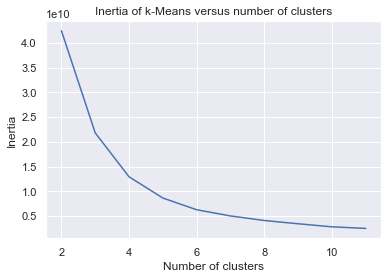

In [137]:
scores = [KMeans(n_clusters=i+2).fit(df).inertia_ 
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")
#The curve elbows off at 4, means 4 clusters will be most beneficial for this analysis

In [138]:
from sklearn.preprocessing import MinMaxScaler
kmeans = KMeans(n_clusters=4, random_state=147).fit(df)
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df))
df_scaled['kmeans'] = kmeans.labels_
df_mean = (df_scaled.loc[df_scaled.kmeans!=-1, :]
                    .groupby('kmeans').mean())
df_mean.columns = ['total_unit_price','price_per_quarter','total_quantity', 'quantity_per_quarter', 'direct_order_percent', 'last_quarter_order', 'two_quartersago_order']
df_mean
#The table represents how each variables load on each cluster
#Cluster 2 loads high on almost all variables as well as "last quarter order", meaning they are the cluster most likely to purchase
#Cluster 0 loads the lowest on variables overall, has the lowest value of "last quarter order" of the other clusters, 
#meaning this cluster is the least likely to buy

,total_unit_price,price_per_quarter,total_quantity,quantity_per_quarter,direct_order_percent,last_quarter_order,two_quartersago_order
kmeans,,,,,,,
0,0.009529,0.005791,0.007752,0.013175,0.551278,0.740815,0.547125
1,0.149088,0.060302,0.326839,0.339254,0.927778,1.000000,1.000000
2,0.130507,0.052198,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.134300,0.080363,0.123416,0.136271,0.858696,0.956522,0.956522


In [139]:
X = finaldata.drop('last_quarter_order', axis=1)  
y = finaldata.last_quarter_order 
#KNN is a supervised learning clustering technique that will allow the use of a dependent variable to train a model and test it 

In [140]:
X

,total_unit_price,price_per_quarter,total_quantity,quantity_per_quarter,direct_order_percent,two_quartersago_order
0,481.21,96.242000,2458,491.600000,0.600000,1
1,178.71,44.677500,2341,585.250000,0.750000,0
2,2211.10,737.033333,470,156.666667,1.000000,1
3,188.87,62.956667,1591,530.333333,0.333333,0
4,157.21,78.605000,248,124.000000,0.500000,1
...,...,...,...,...,...,...
2532,7.65,2.550000,80,26.666667,0.333333,1
2533,37.88,18.940000,67,33.500000,0.500000,0
2534,62.68,31.340000,98,49.000000,0.500000,1
2535,1220.93,305.232500,1397,349.250000,0.750000,1


In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
#Data is split into 25%test and 75%train

In [142]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)
#Fit knn model on train data

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [143]:
y_pred = knn.predict(X_test)
#predict on test data

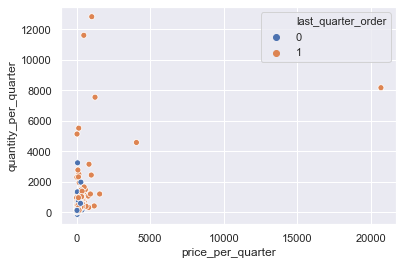

In [144]:
sns.scatterplot(
    x='price_per_quarter',
    y='quantity_per_quarter',
    hue='last_quarter_order',
    data=X_test.join(y_test, how='outer')
)
#scatter plot shows that all customers that order over 4000 units and over $1000 per quarter ordered last quarter

In [145]:
confusion_matrix(y_test, y_pred)
#73% Accuracy

array([[ 50,  94],
       [ 77, 414]], dtype=int64)

In [146]:
knn = KNeighborsClassifier(n_neighbors=4, metric='euclidean')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
confusion_matrix(y_test, y_pred)
#4 Clusters
#69% accuracy

array([[ 73,  71],
       [128, 363]], dtype=int64)

In [147]:
knn = KNeighborsClassifier(n_neighbors=6, metric='euclidean')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
confusion_matrix(y_test, y_pred)
#6 Clusters
#70% accuracy

#4 Clusters is the optimal ammount to predict customer orders in the most recent quarter.

array([[ 62,  82],
       [105, 386]], dtype=int64)

In [148]:
#By grouping and aggregating the data, there are no duplicate customers present in the data. This allows for KNN to predict
#if a single customer will purchase next. By using quarter 4 of 2014 as the independent variable, knn predicts if the customers
#in the test set will purchase in the last 3 months. 4 clusters is determined the optimal ammount clusters from the curve
#as it allows provides for the highest accuracy metrics when predicting in the test set. Kmeans is done preliminarily to
#visualize trends and groups of customers on certain variables, although kmeans is unsupervised and knn is supervised,
#kmeans allows for interpretation of clusters before the data is put into a clustering model and used to predict for 
#the dependent variable. 

#According to kmeans: 
#Cluster 0: Less likely to order next quarter
#Cluster 2: Repeat customers that are likely to order next quarter in bulk.
#Cluster 1&3: Newer customers that are likely to order but not in bulk.

#Insights:
#Customers that purchased in in bulk were more likely to purchase again in the next quarter
#Customers that purchased in the previous quarter were likely to purchase again the next quarter
#Customers with high totals of quantity and price were likely to purchase again.
#Customers who are less likely to purchase dont purchase in bulk and have low totals of quantity and price 


#KNN 
#4 clusters are optimal
#73% accuracy at predicted a purchase in the last quarter when testing on the 25% testing set
